In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data = pd.read_csv('mendeley_dataset.csv')

# Group the data by 'genre' and count the number of entries in each group
genre_counts = data['genre'].value_counts(normalize=True)

# Plot the probability of each genre as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Probability of Each Genre', fontsize=16, pad=22)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Save the plot as a .png file
plt.savefig('static/genre_probability.png')
plt.close()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import joblib

# Load the dataset
df = pd.read_csv('mendeley_dataset.csv')

# Preprocessing: drop rows with missing lyrics or genres and lowercase the lyrics
df = df.dropna(subset=['lyrics', 'genre'])
df['lyrics'] = df['lyrics'].str.lower()

# Balancing the classes through downsampling
min_count = df['genre'].value_counts().min()
balanced_df = df.groupby('genre').apply(lambda x: x.sample(min_count, random_state=42)).reset_index(drop=True)

# Split the dataset into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['lyrics'],
    balanced_df['genre'],
    test_size=0.2,
    random_state=42,
    stratify=balanced_df['genre']  # Stratify here
)

# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Create a TF-IDF vectorizer and RandomForest Classifier in a Pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train_encoded)

# Save the model and the label encoder to disk
joblib.dump(pipeline, 'music_genre_classifier.pkl')
joblib.dump(label_encoder, 'music_genre_label_encoder.pkl')

# Function to predict the genre
def predict_genre(lyrics):
    lyrics = [lyrics.lower()]  # Our model expects a list of items
    lyrics_transformed = pipeline['tfidf'].transform(lyrics)
    genre_code = pipeline['clf'].predict(lyrics_transformed)
    genre = label_encoder.inverse_transform(genre_code)
    return genre[0]


Accuracy: 0.36808846761453395
              precision    recall  f1-score   support

       blues       0.22      0.31      0.26       180
     country       0.37      0.46      0.41       181
     hip hop       0.64      0.78      0.70       181
        jazz       0.26      0.30      0.28       181
         pop       0.26      0.17      0.20       181
      reggae       0.51      0.29      0.37       181
        rock       0.33      0.26      0.29       181

    accuracy                           0.37      1266
   macro avg       0.37      0.37      0.36      1266
weighted avg       0.37      0.37      0.36      1266



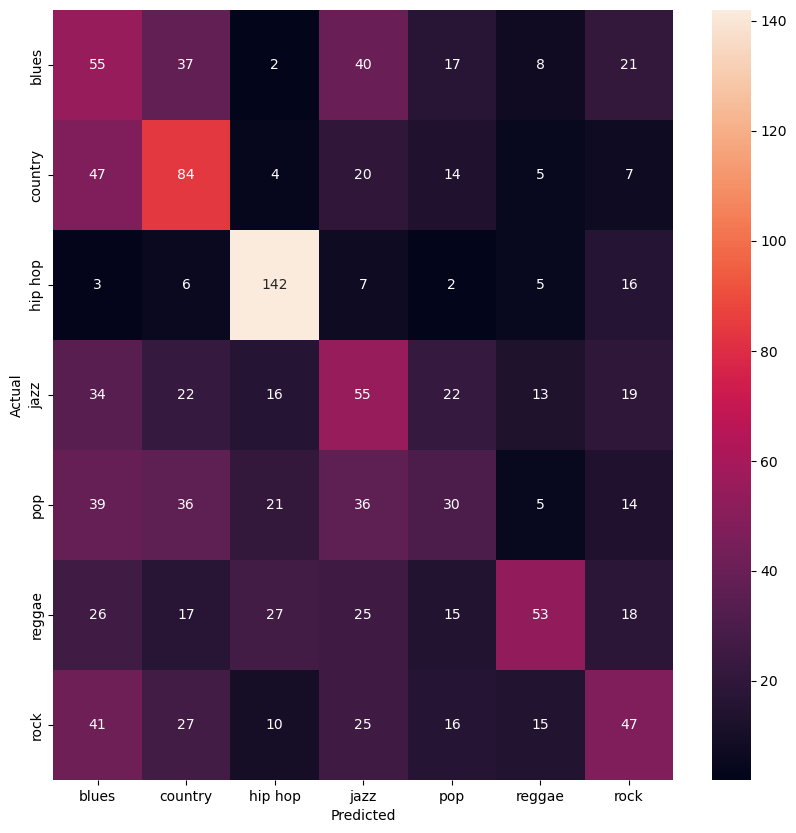

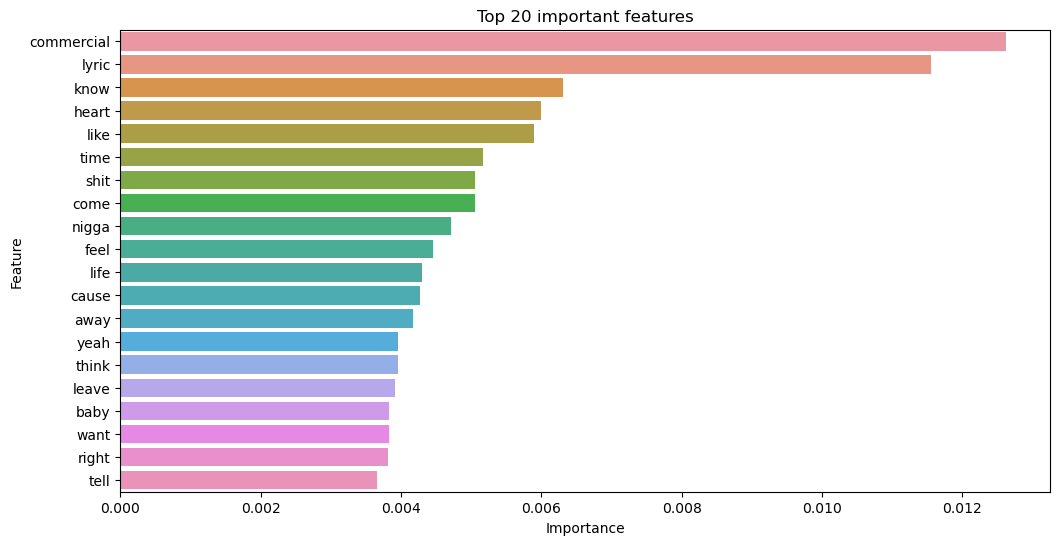

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the test set
y_pred = pipeline.predict(X_test)

# Decode the predicted genres for comparison
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)

# Calculate the accuracy
accuracy = accuracy_score(y_test_decoded, y_pred_decoded)
print(f'Accuracy: {accuracy}')

# Generate a classification report
print(classification_report(y_test_decoded, y_pred_decoded))

# Plotting the confusion matrix
conf_mat = confusion_matrix(y_test_decoded, y_pred_decoded)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plotting the most important features
if 'RandomForestClassifier' in str(pipeline.steps[-1][1]):
    feature_importances = pipeline.steps[-1][1].feature_importances_
    tfidf_feature_names = pipeline.steps[0][1].get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': tfidf_feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).head(20)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 20 important features')
    plt.show()

In [ ]:
# Example usage:
#sample_lyrics = "good times these are the good times leave your cares behind these are the good times good times these are the good times our new state of mind these are the good times happy days are here again the time is right for makin' friends let's get together, how 'bout a quarter to ten? come tomorrow, let's all do it again boys will be boys, better let them have their toys girls will be girls, cute ponytails and curls must put an end to this stress and strife i think i want to live the sporting life good times these are the good times leave your cares behind these are the good times good times these are the good times our new state of mind these are the good times you might also like a rumor has it that it's getting late time marches on, just can't wait the clock keeps turning, why hesitate? you silly fool; you can't change your fate let's cut the rug, a little jive and jitterbug we want the best, we won't settle for less don't be a drag; participate clams on the half shell, and roller skates, roller skates good times these are the good times leave your cares behind these are the good times good times these are the good times our new state of mind these are the good times good times a rumor has it that it's getting late time marches on, just can't wait the clock keeps turning, why hesitate? you silly fool; you can't change your fate let's cut the rug, a little jive and jitterbug we want the best, we won't settle for less don't be a drag; participate clams on the half shell, and roller skates, roller skates good times these are the good times leave your cares behind these are the good times good times these are the good times our new state of mind these are the good times good times these are the good times leave your cares behind these are the good times good times these are the good times our new state of mind these are the good times good times these are the good times leave your cares behind these are the good times good times2embed"
sample_lyrics = "blue sky smile blue sky bluebirds sing song bluebirds long shin bright things go right notice days hurry blue days go blue sky blue sky smile blue sky shin bright things go right notice days hurry blue days go blue sky blue sky"
predicted_genre = predict_genre(sample_lyrics)
print(f"The predicted genre for the provided lyrics is: {predicted_genre}")

The predicted genre for the provided lyrics is: jazz
